

**TRANSFER LEARNING PARA CLASIFICACIÓN DE IMÁGENES**


Lo primero para entrenar el modelo es darle una base de conocimiento para que pueda aprender.

En nuestro caso, la base de datos tiene 3 categorías de objetos de escritorio: cartuchera, calculadora y engrapadora.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ahora que tenemos los datos en Drive, vamos a cargarlos y “acomodarlos” para el modelo MobileNetV2.
En esta parte haremos lo siguiente:

* Determinar las clases a partir del nombre de las carpetas

* Convertir cada imagen a 224×224×3, porque el modelo solo acepta ese tamaño

* Crear batches para el entrenamiento

* Convertir las etiquetas a formato categorical

* Mezclar el orden de las imágenes para que el modelo no vea siempre la misma secuencia

In [2]:
import tensorflow as tf
import numpy as np

data_dir = "/content/drive/MyDrive/IA_proyecto_final/dataset"
img_size = (224, 224)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical")

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical")

class_names = train_ds.class_names
print("clases del modelo:", class_names) # esto solo para usarlo aqui en la pagina no lo cupamos
# Train: 160-Calculadora, 160-Cartuchera, 86-Engrapadora, Total:406
# Val: 57-Calculadora, 37-Cartuchera, 20-Engrapadora, Total:114

Found 406 files belonging to 3 classes.
Found 114 files belonging to 3 classes.
clases del modelo: ['calculadora', 'cartuchera', 'engrapadora']


Con esto activamos prefetch para que TensorFlow prepare el siguiente batch mientras la GPU/CPU está entrenando. Además, mezclamos las imágenes del conjunto de entrenamiento para que el modelo generalice mejor.

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Ahora que tenemos el dataset listo, vamos a armar la arquitectura del modelo usando transfer learning.

Vamos a usar MobileNetV2 y usarlo como extractor de características, quitándole la parte de clasificación original para reemplazarla por nuestras 3 clases.

In [4]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    alpha=1.0,
    weights="imagenet")

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


En esta parte para adelante realizamos ya realizaremos la construccion del modelo, por lo que partimos primero haciendo que el modelo 'vea' mas imagenes que las que ya tenemos en nuestro datset, esto es para aumaentar la cantidad de caracteristicas que puede tener.

In [5]:
from tensorflow.keras import layers, models

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),], name="data_augmentation")

In [6]:
rescale = layers.Rescaling(1./127.5, offset=-1)

inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = models.Model(inputs, outputs, name="cartuchera_calculadora_engrapadora_model")

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

In [8]:
from tensorflow.keras import optimizers

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",
    metrics=["accuracy"])

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[stop])


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.3954 - loss: 1.2385 - val_accuracy: 0.9298 - val_loss: 0.3736
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 750ms/step - accuracy: 0.8618 - loss: 0.4345 - val_accuracy: 0.9737 - val_loss: 0.1731
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 780ms/step - accuracy: 0.8872 - loss: 0.2710 - val_accuracy: 0.9912 - val_loss: 0.1091
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 693ms/step - accuracy: 0.9361 - loss: 0.1790 - val_accuracy: 0.9912 - val_loss: 0.0803
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 788ms/step - accuracy: 0.9838 - loss: 0.1052 - val_accuracy: 0.9912 - val_loss: 0.0613
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 783ms/step - accuracy: 0.9699 - loss: 0.1232 - val_accuracy: 0.9912 - val_loss: 0.0538
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 780ms/step - accuracy: 0.9724 - loss: 0.1009 - val_accuracy: 0.9912 - val_loss: 0.0448
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 749ms/step - accuracy: 0.9900 - loss: 0.0687 - val_accura

Listo, por esta parte tenemos el modelo listo, pero para probarlo antes de llevarlo a la pagina web con streamlit, vamos a realizar unas pruebas sencillas aqui de la mismsa forma que hemos visto en clases.


In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def preparar_imagen(ruta):
    im = Image.open(ruta).convert("RGB")
    im = im.resize(img_size)

    arr = np.array(im)
    plt.imshow(arr)
    plt.axis("off")
    plt.show()

    x = np.expand_dims(arr, axis=0)
    return x

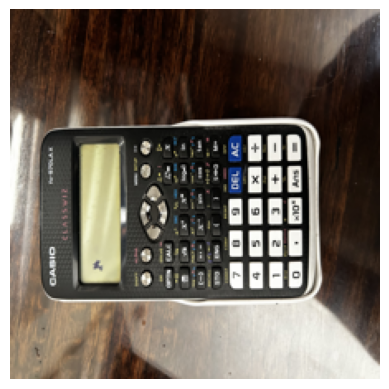

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Probabilidades: [9.9997413e-01 1.2966313e-05 1.2878114e-05]
Predicción: calculadora


In [12]:
# esto se puede comentar para el momento de descargar el modelo ya que es unicmaente para pobrarlo dentro del Colab
x = preparar_imagen("pru6.jpeg")
pred = model.predict(x)[0]
idx = np.argmax(pred)

print("Probabilidades:", pred)
print("Predicción:", class_names[idx])

Finalmente, guardamos el modelo en formato .h5 para usarlo en la aplicación de Streamlit, este formato es compatible, fácil de cargar y funciona bien en distintos entornos.

Como el modelo solo se usa para predicción y no para seguir entrenando, el formato .h5 es suficiente y más seguro que .keras.

In [13]:
model.save("modelo_objetos_tf.h5", save_format="h5")